# Data Preprocessing of Presidential Debate 2024 (Trump vs Harris)

In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [2]:
# load the abcnews_transcript file from the data folder
with open('../data/abcnews_transcript.txt', 'r') as file:
    data = file.read()

In [3]:
trumps_responses = []
kamalas_responses = []

trump_identifier = "FORMER PRESIDENT DONALD TRUMP: "
kamala_identifier = "VICE PRESIDENT KAMALA HARRIS: "

for line in data.split('\n'):
    if line.startswith(trump_identifier):
        trumps_responses.append(line[len(trump_identifier):])
    elif line.startswith(kamala_identifier):
        kamalas_responses.append(line[len(kamala_identifier):])

print('Number of Trump responses:', len(trumps_responses))
print('Number of Kamala responses:', len(kamalas_responses))

# print the first response from each
print()
print('Trump:', trumps_responses[0])
print('Kamala:', kamalas_responses[0])

Number of Trump responses: 74
Number of Kamala responses: 34

Trump: Nice to see you. Have fun.
Kamala: Kamala Harris. Let's have a good debate.


In [13]:
from transformers import AutoTokenizer, AutoModelForTokenClassification
import torch

# Specify the GPU
gpu_id = 1
device = torch.device(f"cuda:{gpu_id}")

# Load the model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("HiTZ/xlm-roberta-large-metaphor-detection-en")
model = AutoModelForTokenClassification.from_pretrained("HiTZ/xlm-roberta-large-metaphor-detection-en")

# Move the model to the specified GPU
model = model.to(device)

# Define the label mapping based on the provided dictionary
label_mapping = {
    0: "B-METAPHOR",  # Beginning of a metaphor
    1: "I-METAPHOR",  # Inside a metaphor
    2: "O"            # Outside any metaphor
}

# Function to classify metaphors in a sentence
def classify_metaphor(sentence):
    # Tokenize the sentence
    inputs = tokenizer(sentence, return_tensors="pt", padding=True, truncation=True)
    
    # Move the inputs to the same GPU
    inputs = {key: value.to(device) for key, value in inputs.items()}
    
    # Get predictions from the model
    with torch.no_grad():
        outputs = model(**inputs)

    # Get the predicted token labels
    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)

    # Convert token ids back to words and extract predicted labels
    tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
    predicted_labels = predictions[0].cpu().numpy()

    # Map predicted labels to human-readable format and filter metaphor tokens
    metaphor_tokens = [tokens[i] for i in range(len(tokens)) if label_mapping[predicted_labels[i]] in ["B-METAPHOR", "I-METAPHOR"]]

    return metaphor_tokens


Metaphor tokens: ['▁sai', 'led']


In [17]:
# List of test sentences
test_sentences = [
    "She had a heart of stone.",  # Conventional metaphor
    "Time is a thief that steals our moments.",  # Abstract metaphor
    "The wind whispered secrets through the trees.",  # Personification
    "The journey to success was a rollercoaster of emotions, but I finally reached the finish line.",  # Mixed metaphor
    "The cat sat on the mat."  # Non-metaphorical sentence
]

# Function to evaluate a list of sentences
def evaluate_sentences(sentences):
    for sentence in sentences:
        metaphors = classify_metaphor(sentence)
        if metaphors:
            print(f"Sentence: '{sentence}'")
            print(f"Metaphor tokens: {metaphors}")
        else:
            print(f"Sentence: '{sentence}' contains no metaphor.")

# Evaluate the list of test sentences
evaluate_sentences(test_sentences)


Sentence: 'She had a heart of stone.'
Metaphor tokens: ['▁heart']
Sentence: 'Time is a thief that steals our moments.'
Metaphor tokens: ['▁thi', 'ef', '▁ste', 'als']
Sentence: 'The wind whispered secrets through the trees.'
Metaphor tokens: ['▁w', 'hi', 'sper', '▁secret']
Sentence: 'The journey to success was a rollercoaster of emotions, but I finally reached the finish line.'
Metaphor tokens: ['▁journey', '▁roller', 'co', 'a', 'ster', '▁reached', '▁finish', '▁line']
Sentence: 'The cat sat on the mat.' contains no metaphor.


In [21]:
# Count the number of metaphors in Trump's responses
# For this, break down each response into sentences and classify metaphors in each sentence
trump_metaphor_count = 0

for response in trumps_responses:
    # Split the response into sentences
    sentences = response.split(".")
    
    # Classify metaphors in each sentence
    for sentence in sentences:
        metaphors = classify_metaphor(sentence)
        if metaphors:
            print(sentence, metaphors)
            trump_metaphor_count += 1

print('Number of metaphors in Trump responses:', trump_metaphor_count)



 Other countries are going to finally, after 75 years, pay us back for all that we've done for the world ['▁back']
 And the tariff will be substantial in some cases ['▁substantial']
 I took in billions and billions of dollars, as you know, from China ['▁took']
 In fact, they never took the tariff off because it was so much money, they can't ['▁took']
 It would totally destroy everything that they've set out to do ['▁destroy', '▁set']
 They've taken in billions of dollars from China and other places ['▁taken']
 They've left the tariffs on ['▁left']
 Look, we've had a terrible economy because inflation has -- which is really known as a country buster ['▁bu', 'ster']
 It breaks up countries ['▁break']
 We have inflation like very few people have ever seen before ['▁seen']
 But that's being generous because many things are 50, 60, 70, and 80% higher than they were just a few years ago ['▁genero', '▁things', '▁higher']
 On top of that, we have millions of people pouring into our country fro

# Old Analysis

In [4]:
# Now we want to do some basic NLP analysis on the responses of Trump and Kamala
# First, we derive some basic descriptive statistics

# Average number of words per response
trump_avg_words = sum([len(response.split()) for response in trumps_responses]) / len(trumps_responses)
kamala_avg_words = sum([len(response.split()) for response in kamalas_responses]) / len(kamalas_responses)

# Average length of words in responses
trump_avg_word_length = sum([len(word) for response in trumps_responses for word in response.split()]) / sum([len(response.split()) for response in trumps_responses])
kamala_avg_word_length = sum([len(word) for response in kamalas_responses for word in response.split()]) / sum([len(response.split()) for response in kamalas_responses])

# Total number of words in all responses
trump_total_words = sum([len(response.split()) for response in trumps_responses])
kamala_total_words = sum([len(response.split()) for response in kamalas_responses])

# Total number of unique words in all responses
trump_unique_words = len(set([word for response in trumps_responses for word in response.split()]))
kamala_unique_words = len(set([word for response in kamalas_responses for word in response.split()]))

# Average number of unique words per response
trump_avg_unique_words = trump_unique_words / len(trumps_responses)
kamala_avg_unique_words = kamala_unique_words / len(kamalas_responses)

# Average number of sentences per response
trump_avg_sentences = sum([response.count('.') for response in trumps_responses]) / len(trumps_responses)
kamala_avg_sentences = sum([response.count('.') for response in kamalas_responses]) / len(kamalas_responses)

# Now we provide an overview of the results with side by side comparison (T | K) rounded to 2 decimal places
print('Descriptive statistics of Trump and Kamala responses: T | K')
print('Number of responses:', len(trumps_responses), '|', len(kamalas_responses))
print('Average number of words per response:', round(trump_avg_words, 2), '|', round(kamala_avg_words, 2))
print('Average length of words in responses:', round(trump_avg_word_length, 2), '|', round(kamala_avg_word_length, 2))
print('Total number of words in all responses:', trump_total_words, '|', kamala_total_words)
print('Total number of unique words in all responses:', trump_unique_words, '|', kamala_unique_words)
print('Average number of unique words per response:', round(trump_avg_unique_words, 2), '|', round(kamala_avg_unique_words, 2))
print('Average number of sentences per response:', round(trump_avg_sentences, 2), '|', round(kamala_avg_sentences, 2))


Descriptive statistics of Trump and Kamala responses: T | K
Number of responses: 74 | 34
Average number of words per response: 109.36 | 173.79
Average length of words in responses: 4.32 | 4.55
Total number of words in all responses: 8093 | 5909
Total number of unique words in all responses: 1745 | 1611
Average number of unique words per response: 23.58 | 47.38
Average number of sentences per response: 10.69 | 10.35


[nltk_data] Downloading package stopwords to
[nltk_data]     /mounts/Users/cisintern/pwicke/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


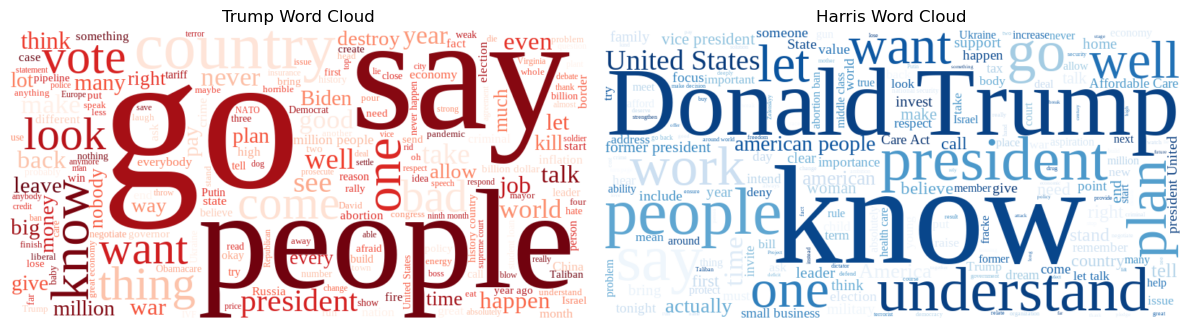

First 5 Trump words: ['nice', 'see', 'fun', 'thank', 'first']
First 5 Harris words: ['Kamala', 'Harris', 'Let', 'good', 'debate']


In [24]:
# Now we want to create word clouds and bar charts to visualize the most common words in the responses of Trump and Kamala
# Remove stopwords from the responses
import nltk
from nltk.corpus import stopwords
import spacy
nltk.download('stopwords')
nlp = spacy.load('en_core_web_sm')
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from collections import Counter

font_path = fm.findfont(fm.FontProperties(family='Liberation Serif'))
stop_words = set(stopwords.words('english'))

# Remove dots and commas from the responses
trumps_responses = [response.replace('–', '').replace('?', '').replace('’', '').replace('.', '').replace(',', '').replace('--', '').replace('\'re', '').replace('\'m', '') for response in trumps_responses]
kamalas_responses = [response.replace('–', '').replace('?', '').replace('’', '').replace('.', '').replace(',', '').replace('--', '').replace('\'re', '').replace('\'m', '') for response in kamalas_responses]

# Lemmatize the words and remove punctuation as well as words distrupted by punctuation
doc = nlp(' '.join(trumps_responses))
trump_words = [token.lemma_ for token in doc if token.is_alpha]
doc = nlp(' '.join(kamalas_responses))
kamala_words = [token.lemma_ for token in doc if token.is_alpha]

# First lemmatize, then remove stopwords!
trump_words = [word for response in trump_words for word in response.split() if word.lower() not in stop_words]
kamala_words = [word for response in kamala_words for word in response.split() if word.lower() not in stop_words]


# Create word clouds
# Use a red color scheme for trump and a blue color scheme for kamala
trump_wordcloud = WordCloud(font_path=font_path, width=800, height=400, background_color='white', colormap='Reds').generate(' '.join(trump_words))
kamala_wordcloud = WordCloud(font_path=font_path, width=800, height=400, background_color='white', colormap='Blues').generate(' '.join(kamala_words))

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(trump_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Trump Word Cloud')

plt.subplot(1, 2, 2)
plt.imshow(kamala_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Harris Word Cloud')

plt.tight_layout()
plt.show()

# print the first 5 trump and kamala words
print('First 5 Trump words:', trump_words[:5])
print('First 5 Harris words:', kamala_words[:5])


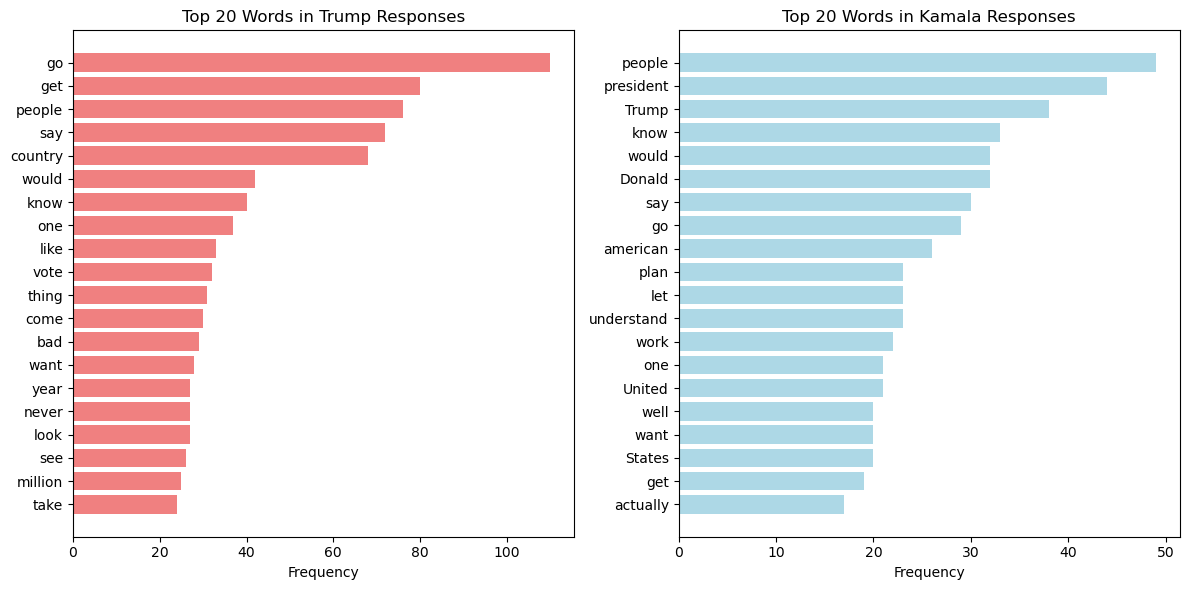

In [6]:
# Now we want to create bar charts to visualize the most common words in the responses of Trump and Kamala
# We will keep the color coding consistent with the word clouds, but in a mute color scheme
# We also want to display the top 10 most common words in each bar chart
# Most frequent words should be at the top of the bar chart

trump_word_freq = Counter(trump_words)
kamala_word_freq = Counter(kamala_words)

trump_top_words = [word for word, _ in trump_word_freq.most_common(20)]
trump_top_freqs = [freq for _, freq in trump_word_freq.most_common(20)]

kamala_top_words = [word for word, _ in kamala_word_freq.most_common(20)]
kamala_top_freqs = [freq for _, freq in kamala_word_freq.most_common(20)]

# Plot the bar charts with most frequent word at the top
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(trump_top_words, trump_top_freqs, color='lightcoral')
plt.xlabel('Frequency')
plt.title('Top 20 Words in Trump Responses')
plt.gca().invert_yaxis()

plt.subplot(1, 2, 2)
plt.barh(kamala_top_words, kamala_top_freqs, color='lightblue')
plt.xlabel('Frequency')
plt.title('Top 20 Words in Kamala Responses')
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()



In [28]:
# Find the most frequent words in Trump and Kamala responses that are not in the other's most frequent words
# We will use the top 20 most frequent words for each

top100_trump = trump_word_freq.most_common(100)
top100_kamala = kamala_word_freq.most_common(100)

trump_unique_words = [(word, freq) for word, freq in top100_trump if word not in [word for word, _ in top100_kamala]]
kamala_unique_words = [(word, freq) for word, freq in top100_kamala if word not in [word for word, _ in top100_trump]]

print('Top 20 unique words in Trump responses:', trump_unique_words[:20])
print('Top 20 unique words in Kamala responses:', kamala_unique_words[:20])


Top 20 unique words in Trump responses: [('like', 33), ('vote', 32), ('thing', 31), ('bad', 29), ('never', 27), ('look', 27), ('see', 26), ('million', 25), ('take', 24), ('good', 21), ('even', 19), ('ever', 18), ('job', 18), ('billion', 16), ('many', 16), ('leave', 15), ('great', 15), ('big', 15), ('pay', 14), ('Biden', 14)]
Top 20 unique words in Kamala responses: [('Donald', 32), ('american', 26), ('understand', 23), ('work', 22), ('States', 20), ('actually', 17), ('America', 17), ('former', 15), ('stand', 14), ('need', 12), ('President', 12), ('woman', 11), ('first', 11), ('tax', 10), ('term', 10), ('home', 9), ('family', 9), ('support', 9), ('business', 9), ('clear', 9)]


([0, 1, 2, 3, 4],
 [Text(0, 0, 'Donald Trump'),
  Text(0, 1, 'John McCain'),
  Text(0, 2, 'Putin'),
  Text(0, 3, 'Joe Biden'),
  Text(0, 4, 'Zelenskyy')])

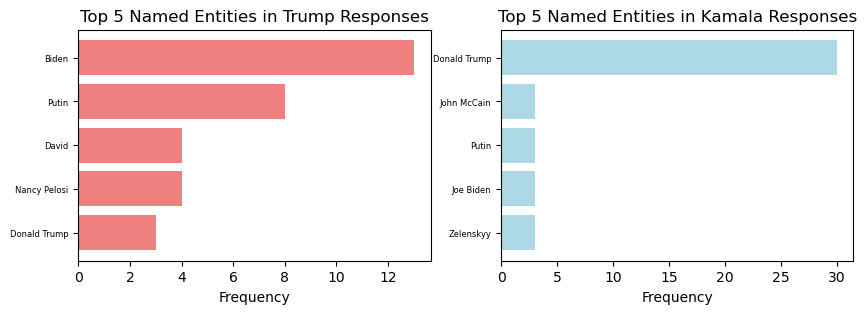

In [30]:
# We want to visualise the most common words that are not verbs or adjectives in the responses of Trump and Kamala
# but named entities

trump_named_entities = [ent.text for response in trumps_responses for ent in nlp(response).ents if ent.label_ == 'PERSON']
kamala_named_entities = [ent.text for response in kamalas_responses for ent in nlp(response).ents if ent.label_ == 'PERSON']

# Remove stopwords from the named entities
trump_named_entities = [entity for entity in trump_named_entities if entity.lower() not in stop_words]
kamala_named_entities = [entity for entity in kamala_named_entities if entity.lower() not in stop_words]

# If entities are in possessive form, remove the 's
trump_named_entities = [entity[:-2] if entity.endswith("'s") else entity for entity in trump_named_entities]
kamala_named_entities = [entity[:-2] if entity.endswith("'s") else entity for entity in kamala_named_entities]

trump_named_entity_freq = Counter(trump_named_entities)
kamala_named_entity_freq = Counter(kamala_named_entities)

trump_top_named_entities = [word for word, _ in trump_named_entity_freq.most_common(5)]
trump_top_named_entity_freqs = [freq for _, freq in trump_named_entity_freq.most_common(5)]

kamala_top_named_entities = [word for word, _ in kamala_named_entity_freq.most_common(5)]
kamala_top_named_entity_freqs = [freq for _, freq in kamala_named_entity_freq.most_common(5)]

# Plot the bar charts with most frequent named entity at the top
plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)
plt.barh(trump_top_named_entities, trump_top_named_entity_freqs, color='lightcoral')
plt.xlabel('Frequency')
plt.title('Top 5 Named Entities in Trump Responses')
plt.gca().invert_yaxis()
plt.yticks(fontsize=6)

plt.subplot(1, 2, 2)
plt.barh(kamala_top_named_entities, kamala_top_named_entity_freqs, color='lightblue')
plt.xlabel('Frequency')
plt.title('Top 5 Named Entities in Kamala Responses')
plt.gca().invert_yaxis()
plt.yticks(fontsize=6)

In [8]:
# How often do either of them use the word "understand" in their responses?
# And how frequently do they use the word "America" in their responses?
trump_understand_freq = trump_word_freq['understand']
kamala_understand_freq = kamala_word_freq['understand']

trump_america_freq = trump_word_freq['America']
kamala_america_freq = kamala_word_freq['America']

print('Frequency of the word "understand" in Trump responses:', trump_understand_freq)
print('Frequency of the word "understand" in Kamala responses:', kamala_understand_freq)
print('Frequency of the word "America" in Trump responses:', trump_america_freq)
print('Frequency of the word "America" in Kamala responses:', kamala_america_freq)

Frequency of the word "understand" in Trump responses: 5
Frequency of the word "understand" in Kamala responses: 23
Frequency of the word "America" in Trump responses: 3
Frequency of the word "America" in Kamala responses: 17


# Topic Modelling - TRUMP
### Evaluating the Cv coherence to chose the topic number

In [9]:
# Cleaning of responses before analysis

# print the first 5 trump responses before cleaning
print('First 5 Trump responses before cleaning:')
for idx, response in enumerate(trumps_responses[:5]):
    print(idx, response)

print('-----------------')

# Clean the responses from stopwords
trump_responses_cleaned = []
for response in trumps_responses:

    # CLEANING
    response = response.replace('.', '').replace(',', '').replace('--', '').replace('\'re', '').replace('\'m', '')
    doc = nlp(response)
    response_cleaned = ' '.join([token.lemma_ for token in doc if token.is_alpha])
    response_cleaned = ' '.join([word for word in response_cleaned.split() if word.lower() not in stop_words])

    trump_responses_cleaned.append(response_cleaned)

# print the first 5 trump responses after cleaning
print('First 5 Trump responses after cleaning:')
for idx, response in enumerate(trump_responses_cleaned[:5]):
    print(idx, response)

# Write the cleaned responses to a new file
with open('../data/trump_responses_cleaned.txt', 'w') as file:
    for response in trump_responses_cleaned:
        file.write(response + '\n')
    

First 5 Trump responses before cleaning:
0 Nice to see you Have fun
1 Thank you
2 First of all I have no sales tax That's an incorrect statement She knows that We doing tariffs on other countries Other countries are going to finally after 75 years pay us back for all that we've done for the world And the tariff will be substantial in some cases I took in billions and billions of dollars as you know from China In fact they never took the tariff off because it was so much money they can't It would totally destroy everything that they've set out to do They've taken in billions of dollars from China and other places They've left the tariffs on When I had it I had tariffs and yet I had no inflation Look we've had a terrible economy because inflation has  which is really known as a country buster It breaks up countries We have inflation like very few people have ever seen before Probably the worst in our nation's history We were at 21% But that's being generous because many things are 50 60 

In [10]:
from gensim.models import CoherenceModel, LdaModel
from gensim.corpora import Dictionary
import matplotlib.pyplot as plt

# Set topic numbers to be tested
min_topics = 1
max_topics = 30

# Create a dictionary from the responses
trump_responses_tokenized = [response.split() for response in trump_responses_cleaned]
trump_dictionary = Dictionary(trump_responses_tokenized)

# Create a bag of words corpus
trump_corpus = [trump_dictionary.doc2bow(response) for response in trump_responses_tokenized]

# Calculate coherence scores for different numbers of topics
coherence_scores = []
for num_topics in range(min_topics, max_topics + 1):
    # Use Gensim's LDA model
    trump_lda_model = LdaModel(corpus=trump_corpus, id2word=trump_dictionary, num_topics=num_topics, random_state=42)
    
    # Calculate coherence using Gensim's LDA model
    coherence_model = CoherenceModel(model=trump_lda_model, texts=trump_responses_tokenized, dictionary=trump_dictionary, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    coherence_scores.append(coherence_score)




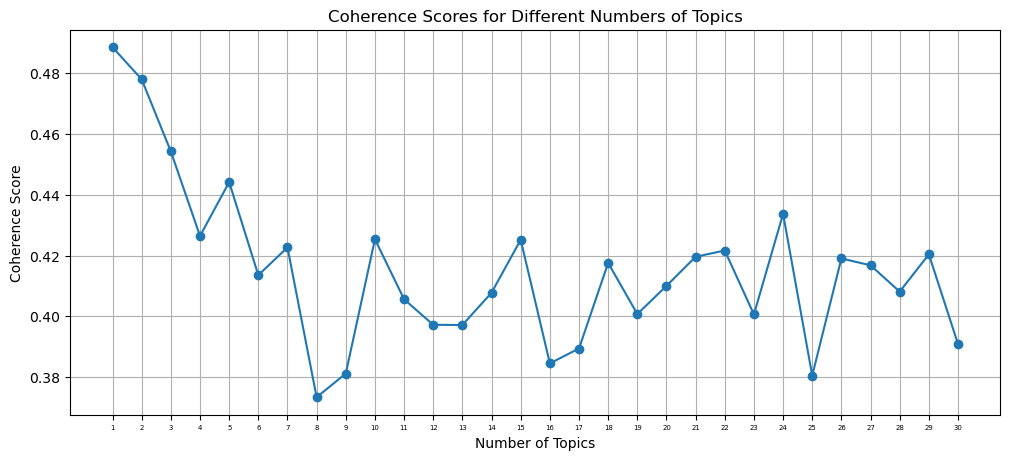

In [11]:
# Plot the coherence scores
plt.figure(figsize=(12, 5))
plt.plot(range(min_topics, max_topics + 1), coherence_scores, marker='o')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
# x ticks should only be integers
plt.xticks(range(min_topics, max_topics + 1, 1))
# xticks smaller font
plt.xticks(fontsize=5)
plt.title('Coherence Scores for Different Numbers of Topics')
plt.grid(True)
plt.show()

In [12]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import pyLDAvis.lda_model

# Create a CountVectorizer object
# Make sure that max_df corresponds to < documents than min_df
# Set stop_words to 'english' to remove common English stopwords
# Set max_df to 0.95 to remove words that appear in more than 95% of the documents
# Set min_df to 2 to remove words that appear in less than 2 documents
# Create the vectorizer and fit the responses
vectorizer = CountVectorizer(stop_words='english', max_df=0.95, min_df=2)
trump_vectorized = vectorizer.fit_transform(trump_responses_cleaned)

# Fit the LDA model
trump_lda = LatentDirichletAllocation(n_components=3, random_state=42)
trump_lda.fit(trump_vectorized)

# Now prepare the pyLDAvis data using the LDA model and vectorizer
pyldavis_data = pyLDAvis.lda_model.prepare(trump_lda, trump_vectorized, vectorizer)

# Store the pyLDAvis data as an HTML file
pyLDAvis.save_html(pyldavis_data, '../output/trump_topics.html')

/mounts/work/pwicke/miniconda3/envs/debate/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=476980) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
/mounts/work/pwicke/miniconda3/envs/debate/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=476980) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
/mounts/work/pwicke/miniconda3/envs/debate/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=476980) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
/mounts/work/pwicke/miniconda3/envs/debate/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=476980) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os

# Topic Modelling - HARRIS
### Evaluating the Cv coherence to chose the topic number

In [13]:
# Cleaning of responses before analysis

# print the first 5 kamala responses before cleaning
print('First 5 Kamalas responses before cleaning:')
for idx, response in enumerate(kamalas_responses[:5]):
    print(idx, response)

print('-----------------')

# Clean the responses from stopwords
kamala_responses_cleaned = []
for response in kamalas_responses:

    # CLEANING
    response = response.replace('.', '').replace(',', '').replace('--', '').replace('\'re', '').replace('\'m', '')
    doc = nlp(response)
    response_cleaned = ' '.join([token.lemma_ for token in doc if token.is_alpha])
    response_cleaned = ' '.join([word for word in response_cleaned.split() if word.lower() not in stop_words])
    
    kamala_responses_cleaned.append(response_cleaned)


# print the first 5 kamala responses after cleaning
print('First 5 kamala responses after cleaning:')
for idx, response in enumerate(kamala_responses_cleaned[:5]):
    print(idx, response)
    
# Write the cleaned responses to a new file
with open('../data/kamala_responses_cleaned.txt', 'w') as file:
    for response in kamala_responses_cleaned:
        file.write(response + '\n')

First 5 Kamalas responses before cleaning:
0 Kamala Harris Let's have a good debate
1 Thank you
2 So I was raised as a middle-class kid And I am actually the only person on this stage who has a plan that is about lifting up the middle class and working people of America I believe in the ambition the aspirations the dreams of the American people And that is why I imagine and have actually a plan to build what I call an opportunity economy Because here's the thing We know that we have a shortage of homes and housing and the cost of housing is too expensive for far too many people We know that young families need support to raise their children And I intend on extending a tax cut for those families of $6000 which is the largest child tax credit that we have given in a long time So that those young families can afford to buy a crib buy a car seat buy clothes for their children My passion one of them is small businesses I was actually  my mother raised my sister and me but there was a woman

In [14]:
from gensim.models import CoherenceModel, LdaModel
from gensim.corpora import Dictionary
import matplotlib.pyplot as plt

# Set topic numbers to be tested
min_topics = 1
max_topics = 30

# Create a dictionary from the responses
kamala_responses_tokenized = [response.split() for response in kamala_responses_cleaned]
kamala_dictionary = Dictionary(kamala_responses_tokenized)

# Create a bag of words corpus
kamala_corpus = [kamala_dictionary.doc2bow(response) for response in kamala_responses_tokenized]

# Calculate coherence scores for different numbers of topics
coherence_scores = []
for num_topics in range(min_topics, max_topics + 1):
    # Use Gensim's LDA model
    kamala_lda_model = LdaModel(corpus=kamala_corpus, id2word=kamala_dictionary, num_topics=num_topics, random_state=42)
    
    # Calculate coherence using Gensim's LDA model
    coherence_model = CoherenceModel(model=kamala_lda_model, texts=kamala_responses_tokenized, dictionary=kamala_dictionary, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    coherence_scores.append(coherence_score)




/mounts/work/pwicke/miniconda3/envs/debate/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=476980) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/mounts/work/pwicke/miniconda3/envs/debate/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=476980) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/mounts/work/pwicke/miniconda3/envs/debate/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=476980) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/mounts/work/pwicke/miniconda3/envs/debate/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=476980) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/mounts/work/pwicke/miniconda3/envs/debate/lib/python3.12/multiprocessing/popen_

/mounts/work/pwicke/miniconda3/envs/debate/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=476980) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/mounts/work/pwicke/miniconda3/envs/debate/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=476980) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/mounts/work/pwicke/miniconda3/envs/debate/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=476980) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/mounts/work/pwicke/miniconda3/envs/debate/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=476980) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/mounts/work/pwicke/miniconda3/envs/debate/lib/python3.12/multiprocessing/popen_

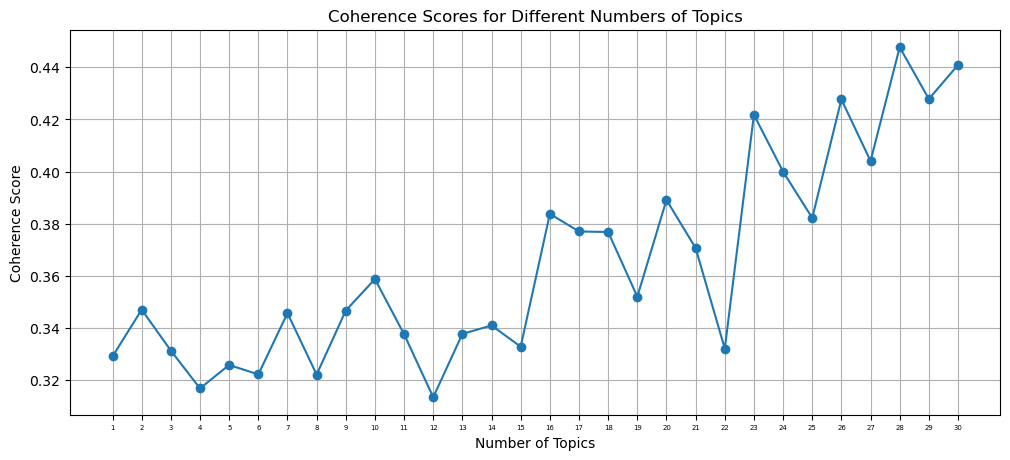

In [15]:
# Plot the coherence scores
plt.figure(figsize=(12, 5))
plt.plot(range(min_topics, max_topics + 1), coherence_scores, marker='o')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
# x ticks should only be integers
plt.xticks(range(min_topics, max_topics + 1, 1))
# xticks smaller font
plt.xticks(fontsize=5)
plt.title('Coherence Scores for Different Numbers of Topics')
plt.grid(True)
plt.show()

In [16]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import pyLDAvis.lda_model

# Create a CountVectorizer object
# Make sure that max_df corresponds to < documents than min_df
# Set stop_words to 'english' to remove common English stopwords
# Set max_df to 0.95 to remove words that appear in more than 95% of the documents
# Set min_df to 2 to remove words that appear in less than 2 documents
# Create the vectorizer and fit the responses
vectorizer = CountVectorizer(stop_words='english', max_df=0.95, min_df=2)
kamala_vectorized = vectorizer.fit_transform(kamala_responses_cleaned)

# Fit the LDA model
kamala_lda = LatentDirichletAllocation(n_components=4, random_state=42)
kamala_lda.fit(kamala_vectorized)

# Now prepare the pyLDAvis data using the LDA model and vectorizer
pyldavis_data = pyLDAvis.lda_model.prepare(kamala_lda, kamala_vectorized, vectorizer)

# Store the pyLDAvis data as an HTML file
pyLDAvis.save_html(pyldavis_data, '../output/kamala_topics.html')

In [17]:
# Provide titles for each of the topics in both models
# by looking at the top words in each topic 

#TODO: This and then let LLM give topic names

    

# Concreteness and Abstraction of Speakers

In [18]:
# In the file "../data/concreteness_brys.txt" we have a list of words with their concreteness scores
# The file format is like this:
# Word	Bigram	Conc.M	Conc.SD	Unknown	Total	Percent_known	SUBTLEX	Dom_Pos
# roadsweeper	0	4.85	0.37	1	27	0.96	0	0
# traindriver	0	4.54	0.71	3	29	0.90	0	0
# tush	0	4.45	1.01	3	25	0.88	66	0

# Frist, we load the file and create a dictionary with the words as keys and their concreteness scores as values
concreteness_scores = {}
with open('../data/concreteness_brys.txt', 'r') as file:
    lines = file.readlines()
    for line in lines[1:]:
        word, _, score, *_ = line.split()
        concreteness_scores[word] = float(score)

print('Number of words with concreteness scores:', len(concreteness_scores))


Number of words with concreteness scores: 37138


In [19]:
# We now want to assess which speaker uses more concrete words in their responses
# which speaker uses more abstract words in their responses
# and we want to visualize the distribution of concreteness scores in the responses of both speakers

# First, we look at a random response and print the concreteness scores of the words in the response
import random
response = random.choice(trump_responses_cleaned)
response_words = response.split()

# Get the concreteness scores of the words in the response, if not found discard the word
response_concreteness_scores = [concreteness_scores.get(word, None) for word in response_words]

# Print the response and the concreteness scores in brackets beside each word
for word, score in zip(response_words, response_concreteness_scores):
    print(f'{word} ({score})', end=' ')
print()



well (1.0) see (3.21) people (4.82) television (1.0) 


In [20]:
# Let's calculate the average concreteness score of the words in the responses of Trump and Kamala
# Considering that some words might not have a concreteness score, we will calculate the average of the scores that are not None 
# The average therefore disregards words that do not have a concreteness score
# For each speaker, we use the _responses_cleaned lists to calculate the average concreteness score

trump_concreteness_scores = [concreteness_scores.get(word, None) for response in trump_responses_cleaned for word in response.split()]
kamala_concreteness_scores = [concreteness_scores.get(word, None) for response in kamala_responses_cleaned for word in response.split()]

# Calculate the average concreteness scores
trump_avg_concreteness = sum(score for score in trump_concreteness_scores if score is not None) / len([score for score in trump_concreteness_scores if score is not None])
kamala_avg_concreteness = sum(score for score in kamala_concreteness_scores if score is not None) / len([score for score in kamala_concreteness_scores if score is not None])

print('Average concreteness score of words in Trump responses:', trump_avg_concreteness)
print('Average concreteness score of words in Kamala responses:', kamala_avg_concreteness)




Average concreteness score of words in Trump responses: 2.0269656992084433
Average concreteness score of words in Kamala responses: 2.1014585115483317


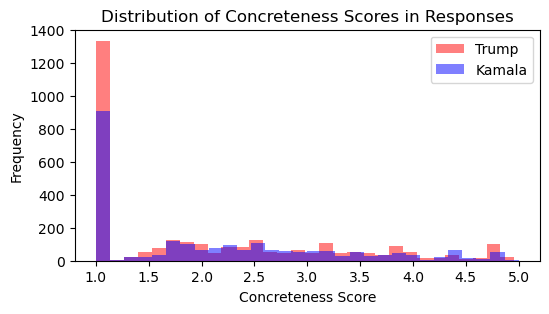

In [21]:
# Now, we want to look at the distribution of concreteness scores in the responses of Trump and Kamala
# We will use histograms to visualize the distribution
# We will remove None values from the concreteness scores before plotting the histograms
# We plot both simultaneously for comparison

# Remove None values from the concreteness scores
trump_conc_scores = [score for score in trump_concreteness_scores if score is not None]
kamala_conc_scores = [score for score in kamala_concreteness_scores if score is not None]

# Plot the histograms with bins next to each other
plt.figure(figsize=(6, 3))
plt.hist(trump_conc_scores, bins=30, alpha=0.5, label='Trump', color='red')
plt.hist(kamala_conc_scores, bins=30, alpha=0.5, label='Kamala', color='blue')
plt.xlabel('Concreteness Score')
plt.ylabel('Frequency')
plt.title('Distribution of Concreteness Scores in Responses')
plt.legend()
plt.show()


In [22]:
# What are the most concrete and abstract words used by Trump and Kamala in their responses?
trump_concrete_words = [word for response in trump_responses_cleaned for word in response.split() if concreteness_scores.get(word, 0) >= 4.5]
trump_abstract_words = [word for response in trump_responses_cleaned for word in response.split() if concreteness_scores.get(word, 0) <= 2.5]

kamala_concrete_words = [word for response in kamala_responses_cleaned for word in response.split() if concreteness_scores.get(word, 0) >= 4.5]
kamala_abstract_words = [word for response in kamala_responses_cleaned for word in response.split() if concreteness_scores.get(word, 0) <= 2.5]

trump_concrete_freq = Counter(trump_concrete_words)
trump_abstract_freq = Counter(trump_abstract_words)

kamala_concrete_freq = Counter(kamala_concrete_words)
kamala_abstract_freq = Counter(kamala_abstract_words)

trump_most_concrete = trump_concrete_freq.most_common(5)
trump_most_abstract = trump_abstract_freq.most_common(5)

kamala_most_concrete = kamala_concrete_freq.most_common(5)
kamala_most_abstract = kamala_abstract_freq.most_common(5)

print('Most Concrete Words in Trump Responses:')
for word, freq in trump_most_concrete:
    print(f'{word}: {freq}')

print('-----------------')

print('Most Abstract Words in Trump Responses:')
for word, freq in trump_most_abstract:
    print(f'{word}: {freq}')

print('-----------------')

print('Most Concrete Words in Kamala Responses:')
for word, freq in kamala_most_concrete:
    print(f'{word}: {freq}')

print('-----------------')

print('Most Abstract Words in Kamala Responses:')
for word, freq in kamala_most_abstract:
    print(f'{word}: {freq}')



Most Concrete Words in Trump Responses:
people: 76
person: 8
student: 7
pipeline: 7
plant: 4
-----------------
Most Abstract Words in Trump Responses:
go: 110
get: 80
country: 68
would: 42
know: 40
-----------------
Most Concrete Words in Kamala Responses:
people: 49
bill: 6
person: 3
senator: 3
kid: 2
-----------------
Most Abstract Words in Kamala Responses:
Trump: 38
know: 33
would: 32
Donald: 32
go: 29
